# Assign Sharpe

This notebook does the bulk of the intermediate processing required for RealAllocator to function. It produces the data file of portfolios with added column of Sharpe ratios for a given market condition cluster. This is accomplished in the following order:

* The historical returns with spectral cluster labels is read in.
* We then filter to obtain only the quarters with the desired label (this must be changed manually for each label).
* The covariance matrix is calculated and basic summary statistics given. The covariance matrix is essential for future steps (calculating the portfolio volatility for the Sharpe ratio), the summary statistics are just to give information about the cluster.
* We then generate the Bayesian posterior (and samples) for the market condition cluster. 
* Each portfolio is then assigned a Sharpe ratio, computed from the Bayesian posterior sample. These ratios are merged witht the original data and written to a new file. Several steps must have manual adjustments to avoid over-writing previous files - this is noted in commentary below.

In [1]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

#Path and file name may need to be changed for future use.
returns = pd.read_csv('/home/jpreszler/github/insight-project/data/sc-label-returns.csv')


## Returns For Specific Label

In [2]:
one_label_returns = returns[returns['SC label']==2]  #change this equality, or don't filter, depending on desired cluster.
one_label_returns = one_label_returns.set_index('Quarter')
one_label_returns = one_label_returns[['Equities', 'Bonds', 'Real Estate', 'Risk Free']]
ASSET_YIELD_COV = one_label_returns.cov().values
one_label_returns.agg(['mean', 'std', 'min', 'max'])

,Equities,Bonds,Real Estate,Risk Free
mean,9.917015,2.351194,2.236696,1.266418
std,3.921653,3.573148,1.775837,0.885213
min,5.230000,-4.900000,-4.790293,0.000000
max,21.310000,15.670000,5.933450,3.530000


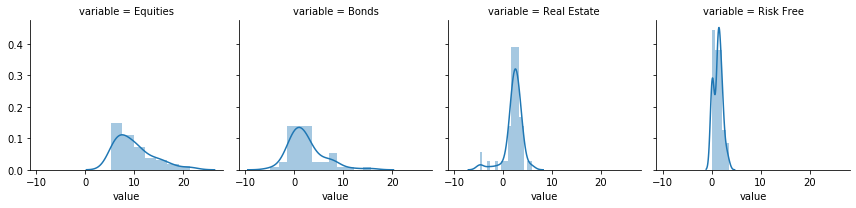

In [3]:
one_label_long = pd.melt(one_label_returns, value_vars = ['Equities', 'Bonds', 'Real Estate', 'Risk Free'])
a = sns.FacetGrid(data=one_label_long, col='variable')
a.map(sns.distplot, 'value', kde=True)

## Build Bayesian Posterior

The following code builds the posterior distribution. Unless you want a significantly different model design, nothing needs to be changed. Several diagnostic plots are created before we sample from the posterior.

This model uses:
* t-distributed returns for each asset class: this is known to be better than normal, but ideally a Tukey-g-h should be used. PyMC3 doesn't have the Tukey-g-h, and for simplicity I stuck with a better known t-distribution.
* I'm assuming the means are standard normally distributed, I have enough data to quickly adjust the centers of each asset class.
* Std. dev. are assumed half-normal with high variation. This reflects that the std. dev. must be positive.
* degrees of freedom are given flat, uninformative priors.

In [4]:
data = [np.array(one_label_returns[col].values) for col in one_label_returns.columns]

# make Bayesian model
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1, shape=4)
    sd = pm.HalfNormal('sd', sd=10, shape=4)
    df = pm.Uniform('df', lower=2, upper=25, shape=4)

    for i,d in enumerate(data):
        pm.StudentT(f'asset_return_obs_{i}',
            mu=mu[i], sd=sd[i],nu=df[i],
            observed=d)
    trace_returns = pm.sample(tune=5000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [df, sd, mu]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:15<00:00, 1443.63draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7935bdbe80>,
      dtype=object)

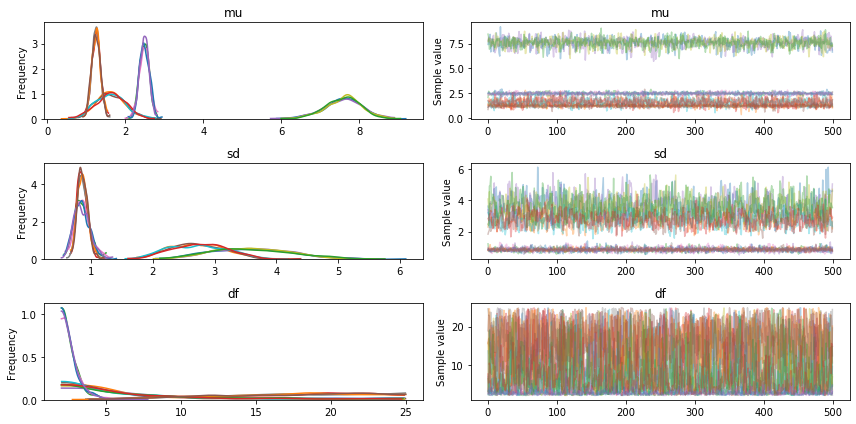

In [5]:
pm.traceplot(trace_returns)

/usr/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/usr/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


GridSpec(1, 2, width_ratios=[3, 1])

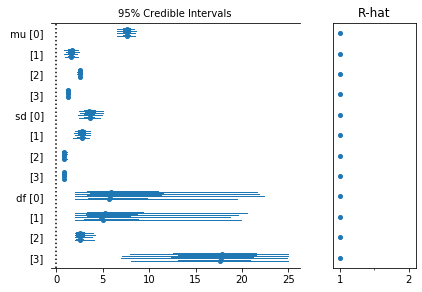

In [6]:
pm.forestplot(trace_returns)


## Sample From Posterior

Since we have good convergence of the MCMC, we can now obtain the samples we will use to compute the Sharpe ratios.

In [7]:
with model:
    post_pred = pm.sample_posterior_predictive(trace_returns, 100)


100%|██████████| 100/100 [00:00<00:00, 320.19it/s]


## Build Return and Volatility Posterior Predictive Data Frames

From the samples, we build dataframes containing the returns and another for the volatility of each asset class. These are the main objects and data (besides the various portfolios) that we work with.

In [8]:
asset_returns_post_pred = pd.DataFrame({k: v[:, 1] for k, v in post_pred.items()})
asset_volatility_post_pred = pd.DataFrame({k: np.apply_along_axis(np.std, axis=1, arr=v[:, 0:4]) for k, v in post_pred.items()})

## Functions to Score each portfolio with Sharpe Ratio

These are the main 'worker' functions. We must calculate each portfolio's return and volatility over the posterior predictive samples. These returns and volatility then allow us to compute the portfolio's Sharpe ratio.

In [13]:
def calc_return_volatility(portfolio, asset_returns, asset_vol, asset_cov):
    """
    calc_return_volatility:
        Computes the return and volatility of a given portfolio with given asset returns, volatility, and covariance.
        
    Returns:
            2 element list of the portfolios average return and volatility.
    Input:
        :param: portfolio: An np.array of asset weights (in [0,1]) that define an investment portfolio
        :param: asset_returns: A dataframe of sample returns for each asset class. Rows are time samples and columns are assets (stocks, bonds, etc.). The number of columns of asset_returns and length of portfolio should match.
        :param: asset_vol: A dataframe of the same shape as asset_returns, but whose values are the volatility of the assets.
        :param: asset_cov: A covariance matrix for the asset classes. 
    """
    port_return = np.sum(asset_returns*portfolio)
    port_volatility = np.sum((portfolio*asset_vol)**2)+2*np.sum(
        [[portfolio[i]*portfolio[j]*asset_cov[i,j] for i in range(0,len(portfolio))] for j in range(i+1, len(portfolio)) ]
    )
    port_volatility = np.sqrt(port_volatility)
    return([port_return, port_volatility]) 

def sharpe_calc(portfolio, asset_returns=asset_returns_post_pred, asset_volatility = asset_volatility_post_pred):
    """
    sharpe_calc:
        computes the sharpe ratio of a given portfolio from the asset returns and volatility dataframes
        
    Return:
        Average Sharpe ratio over the posterior sample of returns
    Input:
        :param: portfolio: an array-like object of asset weights
        :param: asset_returns: a dataframe of returns for each asset class
        :param: asset_volatility: a dataframe of volatilities for each asset
    
    """
    portfolio = np.asarray(portfolio)
    sharpes = []

    # Iterate over post pred samples
    asset_covar = ASSET_YIELD_COV[np.ix_([0,1,2],[0,1,2])]
    for i in range(0, len(asset_returns)):

        port_return, port_vol = calc_return_volatility(
            portfolio,
            asset_returns=asset_returns.iloc[i, 0:3], asset_vol = asset_volatility.iloc[i, 0:3], asset_cov = asset_covar
        )

        
        sharpe_i = ((port_return-asset_returns.iloc[i,3])/port_vol)

        sharpes.append(sharpe_i)

    sharpes = np.asarray(sharpes)

    sharpe = np.ma.masked_equal(sharpes, np.inf)
    return sharpe.mean().round(decimals=3)


## Create Sharpe Ratio for each Portfolio



In [14]:
valid_portfolios = pd.read_csv('/home/jpreszler/github/insight-project/data/3d-portfolios.csv')
valid_portfolios = valid_portfolios[['stock weight', 'bond weight', 'real estate weight']]
cols = ['index', 'Sharpe All']
sscore = pd.DataFrame(columns = cols)
for k, port in valid_portfolios.iterrows():
    sscore = sscore.append(pd.Series([k, sharpe_calc(port)], index=cols), ignore_index=True)
#valid_portfolios['Sharpe '+str(2)] = valid_portfolios.apply(lambda x: assign_sharpe(x))

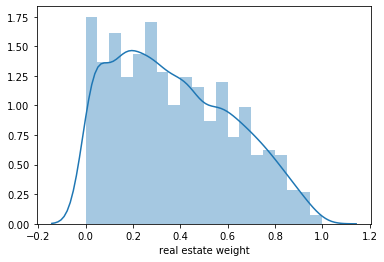

In [15]:
valid_portfolios['Sharpe All'] = sscore['Sharpe All']   #may want to change column name for later merge
high_sharpe = valid_portfolios[valid_portfolios['Sharpe All']> 1]
sns.distplot(high_sharpe['real estate weight'])

In [65]:
valid_portfolios.to_csv('/home/jpreszler/github/insight-project/data/vp-sharpe-gen.csv', index=False)